In [1]:
import os
from pathlib import Path

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

**Pipeline**
1. Load image
2. Convert to grayscale
3. Blur
4. Threshold
5. Morphological clean-up
6. findContours + filter by area
7. Draw results + print metrics

In [15]:
# Utility functions
def imread_rgb(path: str) -> np.ndarray:
    bgr = cv.imread(path, cv.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

def to_gray(rgb: np.ndarray) -> np.ndarray:
    return cv.cvtColor(rgb, cv.COLOR_RGB2GRAY)

def show_grid(items, title=None):
    n = len(items)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(5 * cols, 4 * rows))
    if title:
        plt.suptitle(title)
    for i, (name, img) in enumerate(items, start=1):
        plt.subplot(rows, cols, i)
        plt.title(name)
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [3]:
# Thresholding
''''
Goal: convert grayscale image to binary (black/white) based on some rule - mode.
Modes:
- Global (global): single threshold T for entire image.
  Works when lighting is reasonably uniform.
- Otsu (otsu): automatically finds optimal global threshold that best separates foreground/background (assumes bimodal histogram).
  Good when histogram is roughly bimodal.
- Adaptive (adaptive): dfferent threshold for each local neighborhood
  Best when there are shadows / illumination gradients.
Rule of thumbs:
- If the background brightness changes across the image → adaptive.
- If lighting is stable and object contrast is clear → Otsu (try first).
'''
def threshold_mask(gray_scaled_image: np.ndarray, mode: str) -> tuple[np.ndarray, dict]:    
    debug = {}

    # Light blur reduces noise and makes threshold more stable.
    blur = cv.GaussianBlur(gray_scaled_image, (5, 5), 0)
    debug["blur"] = blur

    if mode == "otsu":
        t, mask = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        debug["otsu_threshold"] = t

    elif mode == "global":
        t = 127
        _, mask = cv.threshold(blur, t, 255, cv.THRESH_BINARY)
        debug["global_threshold"] = t

    elif mode == "adaptive":        
        block_size = 31
        C = 5
        mask = cv.adaptiveThreshold(
            blur, 255,
            cv.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv.THRESH_BINARY,
            block_size, C)
        
        debug["adaptive_blockSize"] = block_size
        debug["adaptive_C"] = C

    else:
        raise ValueError("mode must be one of: 'otsu', 'global', 'adaptive'")

    debug["mask_raw"] = mask
    return mask, debug

In [39]:
# Standardize the appearance of a binary image mask for use in subsequent image processing steps.
"""
Many contour pipelines assume objects are white (255) and background is black (0).
If your result is inverted, flip it.
Heuristic: if most pixels are white, likely background is white -> invert.
"""
def ensure_objects_white(mask: np.ndarray) -> np.ndarray:    
    white_ratio = (mask == 255).mean()
    if white_ratio > 0.6:
        return cv.bitwise_not(mask)
    return mask

In [5]:
# Refine and improve the quality of a binary maskvia  morphological operations.
def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

    # Opening removes small white noise.
    m = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1)

    # Closing fills small holes inside objects.
    m = cv.morphologyEx(m, cv.MORPH_CLOSE, kernel, iterations=1)

    return m

In [22]:
# Identify distinct foreground objects in a binary mask and then discard any objects that are too small.
def find_and_filter_contours(mask: np.ndarray, min_area: float = 800.0):
    contours, hierarchy = cv.findContours(mask.copy(),
                                          cv.RETR_EXTERNAL, 
                                          cv.CHAIN_APPROX_SIMPLE)

    kept = []
    for c in contours:
        area = cv.contourArea(c)
        if area >= min_area:
            kept.append(c)

    # Sort left-to-right for stable outputs (optional).
    kept.sort(key=lambda c: cv.boundingRect(c)[0])
    return kept, hierarchy

In [11]:
# Feature extraction and analysis function.
'''
Goal: take a raw object boundary (a contour) and transform it into: 
- a rich set of quantitative measurements (metrics);
- a simple descriptive classification (label).
'''
def contour_metrics_and_label(contour: np.ndarray) -> dict:
    area = cv.contourArea(contour)
    peri = cv.arcLength(contour, True)

    x, y, w, h = cv.boundingRect(contour)
    aspect = w / (h + 1e-9)

    # Circularity: 1.0 for perfect circle; lower for polygons/irregular shapes.
    circularity = 4 * np.pi * area / (peri * peri + 1e-9)

    # Polygon approximation for “vertex count”
    eps = 0.02 * peri
    approx = cv.approxPolyDP(contour, eps, True)
    vertices = len(approx)

    # Simple labeling heuristic (good enough for general shapes)
    label = "other"
    if vertices == 3:
        label = "triangle"
    elif vertices == 4:
        # Distinguish square-ish vs rectangle-ish
        label = "rectangle" if 0.7 < aspect < 1.3 else "quadrilateral"
    else:
        if circularity > 0.80:
            label = "circle-like"

    return {"area": float(area),
            "perimeter": float(peri),
            "bbox": (int(x), int(y), int(w), int(h)),
            "aspect": float(aspect),
            "circularity": float(circularity),
            "vertices": int(vertices),
            "label": label}

In [12]:
# Visualization and output
def draw_results(rgb: np.ndarray, contours: list[np.ndarray]) -> np.ndarray:
    out = rgb.copy()
    for i, c in enumerate(contours, start=1):
        m = contour_metrics_and_label(c)
        x, y, w, h = m["bbox"]

        cv.rectangle(out, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv.drawContours(out, [c], -1, (255, 0, 0), 2)
        cv.putText(
            out,
            f"#{i} {m['label']}",
            (x, max(0, y - 8)),
            cv.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 0, 0),
            2,
            cv.LINE_AA)
    return out

In [20]:
# Main function

def process_one(path: str, thresh_mode: str, area: float):
    rgb = imread_rgb(path)
    gray = to_gray(rgb)

    mask_raw, dbg = threshold_mask(gray, mode=thresh_mode)
    mask_fixed = ensure_objects_white(mask_raw)
    mask_clean = clean_mask(mask_fixed)

    contours, _ = find_and_filter_contours(mask_clean, min_area=area)
    overlay = draw_results(rgb, contours)

    # Print metrics
    print(f"\nImage: {os.path.basename(path)} | mode={thresh_mode} | contours={len(contours)}")
    for i, c in enumerate(contours, start=1):
        m = contour_metrics_and_label(c)
        print(f"  #{i}: label={m['label']}, area={m['area']:.0f}, vertices={m['vertices']}, circ={m['circularity']:.3f}")

    show_grid([
        ("original", rgb),
        ("gray", gray),
        ("mask_raw", mask_raw),
        ("mask_fixed", mask_fixed),
        ("mask_clean", mask_clean),
        ("overlay", overlay),
    ], title=os.path.basename(path))


Image: img_example_6.jpg | mode=otsu | contours=7
  #1: label=other, area=61, vertices=7, circ=0.645
  #2: label=other, area=58, vertices=7, circ=0.760
  #3: label=other, area=439, vertices=10, circ=0.277
  #4: label=other, area=158, vertices=7, circ=0.731
  #5: label=other, area=4334, vertices=13, circ=0.264
  #6: label=other, area=67, vertices=10, circ=0.564
  #7: label=other, area=37, vertices=8, circ=0.726


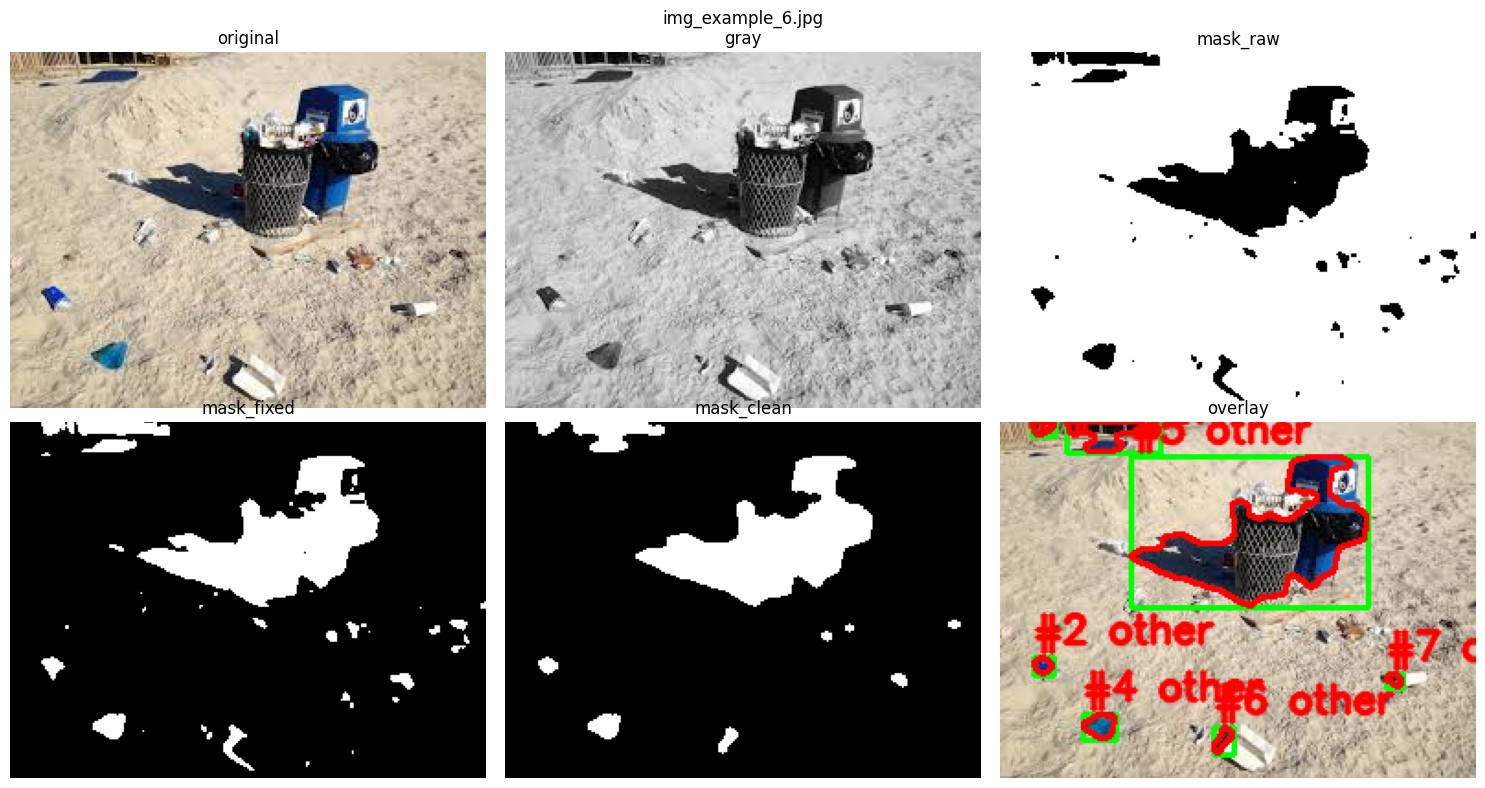

In [56]:
img_path = r'D:\Python things\middle-ml-cv-roadmap\data\raw\img_example_6.jpg'
process_one(img_path, thresh_mode="otsu", area=25.0)